In [1]:
import numpy as np
from grid import Grid
from actors import QLearning
from plot import plotPolicy

g = Grid()
q = QLearning(g)

for episodes in range(2000):
    q.resetCount()
    q.run(epsilon=.1)

# Geradores

## Política

<AxesSubplot: >

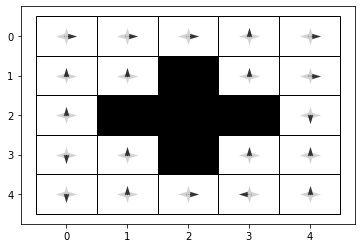

In [2]:
def generatePi(q, g, e=0.1):
    # if not(0 < e < 1):
    #     return -np.inf
    p_a = lambda a, s: (e/4, 1-e+e/4)[a == max(q[s], key=q[s].get)] if 0 < e < 1 else 1e-10
    pi = np.array([[p_a(a, s) for a in g.ACTIONS] for s in g.S])
    return pi.reshape(g.size[0], g.size[1], len(g.ACTIONS), order='F')

pi_star = generatePi(q.Q, g, .3)

from plot import plotPolicy
plotPolicy(pi_star, g)

## Trajetória

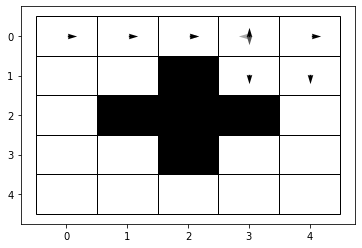

In [3]:
import random
def generateTrajetory(pi, g,  kind=0, size=10):
    s = (0,0)

    arr = []
    for t in range(size):
        a  = random.choices(g.ACTIONS, pi[s], k=1)[0]
        if kind in ['values', 0]:
            step =  (s, a)
        elif kind in ['indexes', 1]:
            step =  (g.S.index(s), g.ACTIONS.index(a))
        elif kind in ['states values', 2]:
            step =  (s, g.ACTIONS.index(a))
        elif kind in ['action values', 3]:
            step =  (g.S.index(s), a)

        s,_,_ = g.transition(s,  a)

        arr.append(step)

    return arr

from plot import plotTrajectory
plotTrajectory(generateTrajetory(pi_star, g), g)

trajectory_pi_star = generateTrajetory(pi_star, g, 2)

# Q-Learning

### Politica 1 - (up,right)

In [4]:
g_1 = Grid()
target_1 = (4,0)
g_1.effects[(4,4)] = {'noise': lambda a: [-a[0], -a[1]]}
g_1.effects[target_1] = {'terminal': True, 'reward': 10}


Episodes: 1999
Steps: 14
Rewards: 8


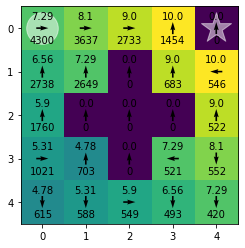

In [5]:
from actors import QLearning

q_1 = QLearning(g_1)

for episodes in range(2000):
    q_1.resetCount()
    q_1.run(epsilon=.9)

print('Episodes:', episodes)
print('Steps:', q_1.steps)
print('Rewards:', q_1.totalReward)

q_1.plot()

<AxesSubplot: >

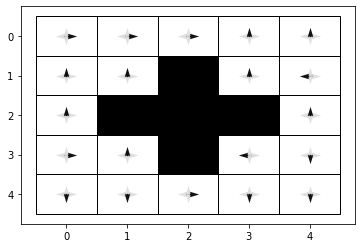

In [6]:
pi_1 = generatePi(q_1.Q, g_1, .1)
plotPolicy(pi_1, g_1)

### Politica 2 - (down,left)

In [7]:
g_2 = Grid()

target_2 = (0,4)
g_2.effects[(4,4)] = {'noise': lambda a: [-a[0], -a[1]]}
g_2.effects[target_2] = {'terminal': True, 'reward': 10}


Episodes: 1999
Steps: 20
Rewards: 2


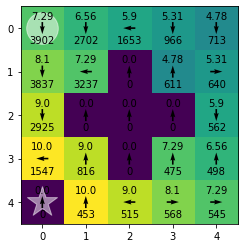

In [8]:
from actors import QLearning

q_2 = QLearning(g_2)

for episodes in range(2000):
    q_2.resetCount()
    q_2.run(epsilon=.9)

print('Episodes:', episodes)
print('Steps:', q_2.steps)
print('Rewards:', q_2.totalReward)

q_2.plot()

<AxesSubplot: >

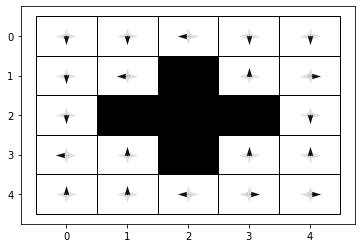

In [9]:
pi_2 = generatePi(q_2.Q, g_2, .1)
plotPolicy(pi_2, g_2)

# Estimadores

## Likelihood

### Glossário
$\xi$ : Trajetória (sequencia de estados e ações) <br>
$\mathcal{H}$ : Conjunto de Options <br>
$\psi_h(s) \in [0,1]$ : Politica de termino (Probabilidade de Término da option $h$ no estado $s$) <br>
$\eta(h|s) $ : Politica Superior (Probabilidade de estar na option $h$ dado o estado $s$)<br>

In [10]:
pH = [
    lambda s: 0 if sum(q_1.Q[s].values()) + sum(q_2.Q[s].values()) == 0 else sum(q_1.Q[s].values()) / (sum(q_1.Q[s].values()) + sum(q_2.Q[s].values())),
    lambda s: 0 if sum(q_1.Q[s].values()) + sum(q_2.Q[s].values()) == 0 else sum(q_2.Q[s].values()) / (sum(q_1.Q[s].values()) + sum(q_2.Q[s].values())),
]

In [11]:
E = generateTrajetory(pi_star, g, kind=1)
psi_1 = [int(s==target_1) for s in g.S]
psi_2 = [int(s==target_2) for s in g.S]
H = [
    (pi_1, psi_1),
    (pi_2, psi_2)
]
eta = np.array([[pH[h](s) for h,_ in enumerate(H)] for s in g.S])

### Trajectory Prefix

$\phi_0(h) = p_0(s_0)\eta(h|s_0)$
<br>
$\phi_{t+1}(h') = \sum_{h \in \mathcal{H}} \lgroup \phi_t(h)\pi_h(a_t|s_t) p(s_{t+1}|s_t, a_t) \psi_h(s_{t+1}) \rgroup \;\; \eta(h'|s_{t+1}) + \phi_t(h') \pi_{h'}(a_t|s_t) p(s_{t+1} | s_t, a_t) (1-\psi_{h'}(s_{t+1})) $

```algorithm
calcula_Phi (t, h)
    se não existe t em phi[h]
        se não existe t-1 em phi[h]
            para cada h_ em H
                phi[h_, t-1] <-  calcula_Phi(h_, t-1)
        phi[h, t] <- PHIt+1(h)  
    devolva phi[h, t]
```

In [12]:
def __phi(t,h):
    s,a = E[t]
    if t==0:
        return eta[s, h]
    
    s_,_ = E[t+1]
    pi, psi = H[h]

    term_1 = sum(phi_table[h_][t-1] * pi_[s,a] * psi_[s_] for h_,(pi_, psi_) in enumerate(H)) * eta[s_, h]
    term_2 = phi_table[h][t] * pi[s, a] * (1-psi[s_])

    return term_1 + term_2 


phi_table = [{0: __phi(0, h)} for h,_ in enumerate(H)]

def prefix_likelihood(h, t):
    if t not in phi_table[h]:
        if t-1 not in phi_table[h]:
            for h_, _ in enumerate(H):
                phi_table[h_][t-1] = prefix_likelihood(h_, t-1)
        phi_table[h][t] = __phi(t, h)
    return phi_table[h][t]

### Trajectory Suffix

$w_{T-1}(h) = \pi_h(a_{T-1}|s_{T-1}) p(s_T | s_{T-1}, a_{T-1}) $
<br>
$w_t(h) = \pi_h(a_t|s_t) p(s_{t+1} | s_t, a_t) \lgroup \psi_h(s_{t+1}) \sum_{h' \in \mathcal{H}} \eta(h'|s_{t+1})w_{t+1}(h') + (1- \psi_h(s_{t+1})) w_{t+1}(h) \rgroup $

```algorithm
calcula_W (t, h)
    se não existe t em w[h]
        se não existe t+1 em w[h]
            para cada h_ em H
                w[h_, t+1] <-  calcula_W(h_, t+1)
        w[h, t] <- Wt(h)  
    devolva w[h, t]
```

In [13]:
def __w(t,h):
    _s,_a = E[-1]
    pi, psi = H[h]
    
    if t==(len(E)-1):
        return pi[g.S[_s]][_a]
    
    s,a = E[t]
    s_,_ = E[t+1]
    
    term_1 = psi[s_] * sum(eta[s_, h_] * w_table[h_][t+1] for h_,_ in enumerate(H))
    term_2 = (1- psi[s_]) * w_table[h][t+1]

    return pi[g.S[s]][a] * (term_1 +  term_2)

w_table = [{(len(E)-1): __w((len(E)-1), h)} for h,_ in enumerate(H)]

def suffix_likelihood(h, t):
    if t not in w_table[h]:
        if t+1 not in w_table[h]:
            for h_, _ in enumerate(H):
                w_table[h_][t+1] = suffix_likelihood(h_, t+1)
        w_table[h][t] = __w(t,h)
    return w_table[h][t]

### Target
$\mathbb{P}_{\theta}(\xi) = \sum_{h \in \mathcal{H}} \phi_t(h)w_t(h)$ 

In [14]:
def likelihood(t):
    phi = prefix_likelihood
    w = suffix_likelihood

    return sum(phi(h, t) * w(h, t) for h,_ in enumerate(H))

likelihood(0)

0.000167488161472416